This notebook is used to get the histogram in the patient-level.

In [1]:
import timm
import torch
import openpyxl
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import torchvision.transforms as transforms
import cv2
import os ,sys
import numpy as np
from openpyxl import Workbook
import matplotlib.pyplot as plt
import math
model = timm.create_model(model_name='resnet18',num_classes = 2,checkpoint_path='D:/dataset_Huo_1/output/resnet18_1-1704.pth')
model = model.eval()

In [3]:
def searchFile(key,startPath = '.'):
    if not os.path.isdir(startPath):
        raise ValueError
    l= [os.path.join(startPath,x) for x in os.listdir(startPath)]  #列出所有文件的绝对路径
    #listdir出来的相对路径 不能用于 isfile  abspath只能用在当前目录
    filelist=[x for x in l if os.path.isfile(x) if key in os.path.splitext(os.path.basename(x))[0]] #文件
    #只查找文件名中  不包括后缀 文件路径
    if not hasattr(searchFile,'basePath'):#把函数当成类 添加属性
        searchFile.basePath=startPath #只有第一次调用才会赋值给basePath
    outmap = map(lambda x:os.path.relpath(x,searchFile.basePath),filelist) #转换成相对于初始路径的相对路径

    outlist = list(outmap) 

    dirlist= [x for x in l if os.path.isdir(x)]  #目录
    for dir in dirlist:
        outlist = outlist + searchFile(key,dir)
 
    return outlist

In [57]:
wb = Workbook()
sheet = wb.active
sheet.title = "MSS_patient_data"
# sheet.title = "MSI_patient_data"
config = resolve_data_config({}, model=model)
# transform = transforms.Compose([
#                     transforms.ToTensor()])
transform = create_transform(**config)
img_result = []
vote_MSI = 0
patient_name = 'TCGA-4N-A93T'
print("patient id:",patient_name)
file_names = searchFile(patient_name,startPath = 'D:/dataset_Huo_1/CRC_DX/train/MSS/')
image_num = len(file_names)
# file_names = searchFile(patient_name,startPath = 'D:/dataset_Huo_1/CRC_DX/train/MSIMUT/')
# image_num = len(file_names)
print("numbers of images of this patient",image_num)
for j in range(image_num):
    # path = 'D:/dataset_Huo_1/CRC_DX/train/MSIMUT/' + file_names[j]
    path = 'D:/dataset_Huo_1/CRC_DX/train/MSS/' + file_names[j]
    image = Image.open(path).convert('RGB')
    tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        out = model(tensor)
    probabilities = torch.nn.functional.softmax(out[0], dim=0)
    probabilities = probabilities.numpy()
    img_result.append(probabilities[0])
    if probabilities[0] >= 0.5:
        vote_MSI = vote_MSI + 1
    print(j,"vote:",probabilities[0])
    sheet["A%d" % (j+1)].value = img_result[j]
print('total number:',len(img_result),'vote_MSI',vote_MSI,'vote',vote_MSI/len(img_result))
# wb.save('D:/dataset_Huo_1/patch2image_test_2.xlsx')

patient id: TCGA-4N-A93T
numbers of images of this patient 767
0 vote: 0.23951063
1 vote: 0.41229114
2 vote: 0.12550728
3 vote: 0.54365766
4 vote: 0.14836732
5 vote: 0.72056615
6 vote: 0.12687103
7 vote: 0.050937388
8 vote: 0.66805375
9 vote: 0.1576961
10 vote: 0.4390903
11 vote: 0.81380683
12 vote: 0.13263951
13 vote: 0.27120417
14 vote: 0.1947716
15 vote: 0.09574495
16 vote: 0.57863426
17 vote: 0.18311086
18 vote: 0.28921843
19 vote: 0.627221
20 vote: 0.33869743
21 vote: 0.40281332
22 vote: 0.07191721
23 vote: 0.15903948
24 vote: 0.1459618
25 vote: 0.30057007
26 vote: 0.3292252
27 vote: 0.15836893
28 vote: 0.22764945
29 vote: 0.072596356
30 vote: 0.1344749
31 vote: 0.601178
32 vote: 0.12737544
33 vote: 0.18146054
34 vote: 0.07508568
35 vote: 0.50727355
36 vote: 0.52944326
37 vote: 0.38984376
38 vote: 0.36486158
39 vote: 0.5125821
40 vote: 0.3659753
41 vote: 0.088522054
42 vote: 0.116454646
43 vote: 0.23649913
44 vote: 0.104248546
45 vote: 0.8813488
46 vote: 0.10032985
47 vote: 0.2207

In [58]:
counts,bins = np.histogram(img_result,bins = 10,range = (0,1))
counts_norm = counts / image_num

(array([117., 161., 134., 104.,  83.,  61.,  49.,  34.,  16.,   8.]),
 array([0.00788731, 0.09523346, 0.1825796 , 0.26992574, 0.3572719 ,
        0.44461805, 0.5319642 , 0.6193103 , 0.7066565 , 0.79400265,
        0.8813488 ], dtype=float32),
 <a list of 10 Patch objects>)

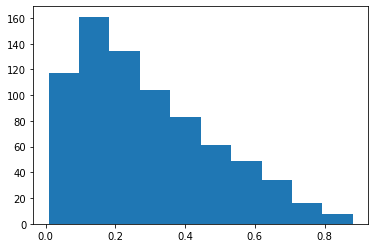

In [59]:
plt.hist(img_result)

In [33]:
def gaussian(x,a,b,c):
    y = a * math.exp(-((x - b)**2) / (2 * c**2))
    return y

In [34]:
decay_factor = np.ones(20)
for k in range(20):
    x = (k + 1) * 0.05 - 0.025
    decay_factor[k] = gaussian(x,1,0.5,math.sqrt(0.02))
decay_factor = 1 - decay_factor
print(decay_factor)

[0.99644935 0.98906323 0.97027078 0.92868332 0.84902258 0.71793705
 0.53495681 0.32336615 0.13118494 0.01550356 0.01550356 0.13118494
 0.32336615 0.53495681 0.71793705 0.84902258 0.92868332 0.97027078
 0.98906323 0.99644935]


In [ ]:
info = openpyxl.load_workbook('D:/dataset_Huo_1/MSIMUT_validation.xlsx')
inf = info.active
from openpyxl import Workbook

patch_info = Workbook()
sheet2 = patch_info.active
sheet2.title = "patch_info"

feature_MSI = Workbook()
sheet3 = feature_MSI.active
sheet3.title = "feature_MSI"

config = resolve_data_config({}, model=model)
transform = create_transform(**config)
right_num = 0
vote1 = []
vote2 = []
for i in range(0,11):
    patient_name = inf.cell(row=1, column=(i+1)).value
    print(i,"patient id:",patient_name)
    file_names = searchFile(patient_name,startPath = 'D:/dataset_Huo_1/CRC_DX/validation/MSIMUT/')
    image_num = len(file_names)
    print("numbers of images of this patient",image_num)
    pred_MSS = 0
    pred_MSI = 0
    patch = []
    if image_num:
        for j in range(image_num):
            path = 'D:/dataset_Huo_1/CRC_DX/validation/MSIMUT/' + file_names[j]
            image = Image.open(path).convert('RGB')
            tensor = transform(image).unsqueeze(0)
            with torch.no_grad():
                out = model(tensor)
            probabilities = torch.nn.functional.softmax(out[0], dim=0)
            if probabilities[0] >= probabilities[1]:
                pred_MSI = pred_MSI + 1
            elif probabilities[0] < probabilities[1]:
                pred_MSS = pred_MSS + 1
            probabilities = np.array(probabilities)
            patch.append(probabilities[0])
            sheet2.cell(j+1,i+1).value = probabilities[0]
        counts,bins = np.histogram(patch,bins = 20,range = (0,1))
        counts_norm = counts / image_num
        for t in range(20):
            sheet3.cell(i+1,t+1).value = counts_norm[t]
        vote_buf1 = pred_MSI / (pred_MSI + pred_MSS)
        if vote_buf1 >= 0.5:
            right_num = right_num + 1
        vote1.append(vote_buf1)
        print(i, "pred_MSI:",pred_MSI,"pred_MSS:",pred_MSS,"vote_MSI:",vote1[i],"mean vote:",sum(vote1)/(i+1))
        # print(i, "vote_MSI_decay:",vote2[i],"mean vote after decay:",sum(vote2)/(i+1))
        print("\n")
        sheet3.cell(i+1,21).value = vote1[i]
print('total number: 11','right number:',right_num)
patch_info.save('D:/dataset_Huo_1/MSI_validation_patch_info.xlsx')
feature_MSI.save('D:/dataset_Huo_1/feature_MSI_val.xlsx')

In [ ]:
info = openpyxl.load_workbook('D:/dataset_Huo_1/MSS_validation.xlsx')
inf = info.active
from openpyxl import Workbook

patch_info = Workbook()
sheet2 = patch_info.active
sheet2.title = "patch_info"

feature_MSS = Workbook()
sheet3 = feature_MSS.active
sheet3.title = "feature_MSS"

config = resolve_data_config({}, model=model)
transform = create_transform(**config)
right_num = 0
vote1 = []
vote2 = []
for i in range(0,61):
    patient_name = inf.cell(row=1, column=(i+1)).value
    print(i,"patient id:",patient_name)
    file_names = searchFile(patient_name,startPath = 'D:/dataset_Huo_1/CRC_DX/validation/MSS/')
    image_num = len(file_names)
    print("numbers of images of this patient",image_num)
    pred_MSS = 0
    pred_MSI = 0
    patch = []
    if image_num:
        for j in range(image_num):
            path = 'D:/dataset_Huo_1/CRC_DX/validation/MSS/' + file_names[j]
            image = Image.open(path).convert('RGB')
            tensor = transform(image).unsqueeze(0)
            with torch.no_grad():
                out = model(tensor)
            probabilities = torch.nn.functional.softmax(out[0], dim=0)
            if probabilities[0] >= probabilities[1]:
                pred_MSI = pred_MSI + 1
            elif probabilities[0] < probabilities[1]:
                pred_MSS = pred_MSS + 1
            probabilities = np.array(probabilities)
            patch.append(probabilities[0])
            sheet2.cell(j+1,i+1).value = probabilities[0]
        counts,bins = np.histogram(patch,bins = 20,range = (0,1))
        counts_norm = counts / image_num
        for t in range(20):
            sheet3.cell(i+1,t+1).value = counts_norm[t]
        vote_buf1 = pred_MSI / (pred_MSI + pred_MSS)
        if vote_buf1 < 0.5:
            right_num = right_num + 1
        vote1.append(vote_buf1)
        print(i, "pred_MSI:",pred_MSI,"pred_MSS:",pred_MSS,"vote_MSI:",vote1[i],"mean vote:",sum(vote1)/(i+1))
        # print(i, "vote_MSI_decay:",vote2[i],"mean vote after decay:",sum(vote2)/(i+1))
        print("\n")
        sheet3.cell(i+1,21).value = vote1[i]
print('total number: 61','right number:',right_num)
patch_info.save('D:/dataset_Huo_1/MSS_validation_patch_info.xlsx')
feature_MSS.save('D:/dataset_Huo_1/feature_MSS_val.xlsx')

In [ ]:
from openpyxl import Workbook
wb = Workbook()
sheet = wb.active
sheet.title = "MSS_patient_data"
# sheet.title = "MSI_patient_data"
config = resolve_data_config({}, model=model)
# transform = transforms.Compose([
#                     transforms.ToTensor()])
transform = create_transform(**config)
img_result = []
vote_MSI = 0
patient_name = 'TCGA-AG-A02N'
print("patient id:",patient_name)
# file_names = searchFile(patient_name,startPath = 'D:/dataset_Huo_1/CRC_DX/test/MSS/')
# image_num = len(file_names)
file_names = searchFile(patient_name,startPath = 'D:/dataset_Huo_1/CRC_DX/test/MSIMUT/')
image_num = len(file_names)
print("numbers of images of this patient",image_num)
for j in range(image_num):
    path = 'D:/dataset_Huo_1/CRC_DX/test/MSIMUT/' + file_names[j]
    # path = 'D:/dataset_Huo_1/CRC_DX/test/MSS/' + file_names[j]
    image = Image.open(path).convert('RGB')
    tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        out = model(tensor)
    probabilities = torch.nn.functional.softmax(out[0], dim=0)
    probabilities = probabilities.numpy()
    img_result.append(probabilities[0])
    if probabilities[0] >= 0.5:
        vote_MSI = vote_MSI + 1
    print(j,"vote:",probabilities[0])
    sheet["A%d" % (j+1)].value = img_result[j]
print('total number:',len(img_result),'vote_MSI',vote_MSI,'vote',vote_MSI/len(img_result))
# wb.save('D:/dataset_Huo_1/patch2image_test_2.xlsx')

In [ ]:
# bins = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
counts,bins = np.histogram(img_result,bins = 20,range = (0,1))
print(counts)
# plt.hist(img_result,bins = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1])

[  0   0   0   0   0   3   3   2   5   7   8  20  30  39  49  68  94 113
  63   4]


In [ ]:
# decay_factor = [0.95,0.85,0.75,0.65,0.55,0.45,0.35,0.25,0.15,0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95]
decay_factor = np.ones(20)
for k in range(20):
    x = (k + 1) * 0.05 - 0.025
    decay_factor[k] = gaussian(x,1,0.5,math.sqrt(0.02))
decay_factor = 1 - decay_factor
print(decay_factor)
counts_norm = counts / len(img_result)
# print(counts_norm)
# print(counts_norm[0:10])
# print(counts_norm[10:20])
for t in range(20):
    counts_norm[t] = counts_norm[t] * decay_factor[t]
mss = sum(counts_norm[0:10])
msi = sum(counts_norm[10:20])
msi / (mss + msi)

[0.99644935 0.98906323 0.97027078 0.92868332 0.84902258 0.71793705
 0.53495681 0.32336615 0.13118494 0.01550356 0.01550356 0.13118494
 0.32336615 0.53495681 0.71793705 0.84902258 0.92868332 0.97027078
 0.98906323 0.99644935]


0.06719135789696319

(array([38., 68., 60., 48., 45., 48., 25., 25., 27., 21., 11., 21., 15.,
        14.,  9.,  6.,  6.,  2.,  1.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

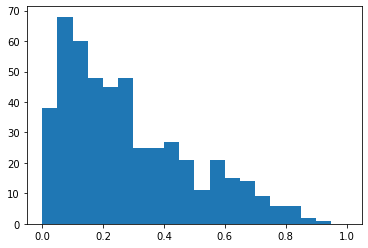

In [ ]:
plt.hist(img_result,bins = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1])